# **MODULE 3 PROJECT: Build a basic GAN model to genertae images from a dataset.**

In [1]:
import tensorflow as tf

# Loading MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# range normalization [-1, 1]
train_images = (train_images - 127.5) / 127.5  # Rescale pixel values
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")

# dataset pipeline
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

# Checking dataset shape
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Batch shape: (128, 28, 28, 1)


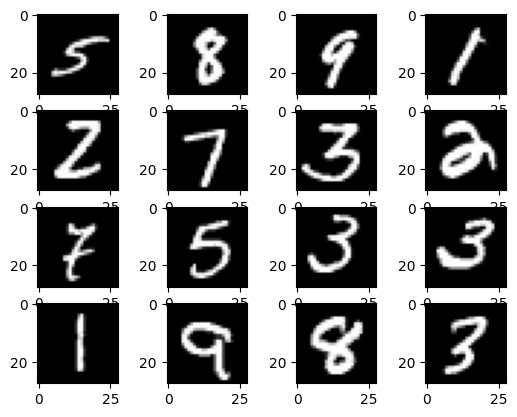

In [5]:
#show the loaded data
import matplotlib.pyplot as plt
#visualize loaded data
for batch in train_dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(batch[i, :, :, 0], cmap='gray')



# GAN Architecture


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# Generator Model
def build_generator(noise_dim=100):
    model = keras.Sequential([
        layers.Dense(256, activation="relu", input_shape=(noise_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(28*28, activation="tanh"),  # Output [-1,1]
        layers.Reshape((28, 28, 1))
    ])
    return model

# Discriminator Model
def build_discriminator():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(1024, activation=keras.layers.LeakyReLU(0.2)),
        layers.Dense(512, activation=keras.layers.LeakyReLU(0.2)),
        layers.Dense(256, activation=keras.layers.LeakyReLU(0.2)),
        layers.Dense(1, activation="sigmoid")  # Output probability
    ])
    return model

# Model initialization
gen = build_generator()
disc = build_discriminator()

print("Generator Summary:")
gen.summary()
print("\nDiscriminator Summary:")
disc.summary()


Generator Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [3]:
import numpy as np

# Loss function
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizers
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Defining Training Step
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise_dim = 100
    noise = tf.random.normal([batch_size, noise_dim])

    # Training Generator & Discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = gen(noise, training=True)

        real_output = disc(real_images, training=True)
        fake_output = disc(fake_images, training=True)

        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)  # Fool Discriminator
        d_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                 cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Compute Gradients and Apply Optimizers
    gradients_of_generator = gen_tape.gradient(g_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

    return g_loss, d_loss

# Training Loop
epochs = 50
for epoch in range(epochs):
    for batch in train_dataset:
        g_loss, d_loss = train_step(batch)

    print(f"Epoch {epoch+1}/{epochs}  D Loss: {d_loss:.4f}  G Loss: {g_loss:.4f}")

# Save the trained generator model
gen.save("gan_generator.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50  D Loss: 0.1556  G Loss: 4.5912
Epoch 2/50  D Loss: 1.0671  G Loss: 0.4472
Epoch 3/50  D Loss: 0.1026  G Loss: 3.5363


KeyboardInterrupt: 

# Visualization

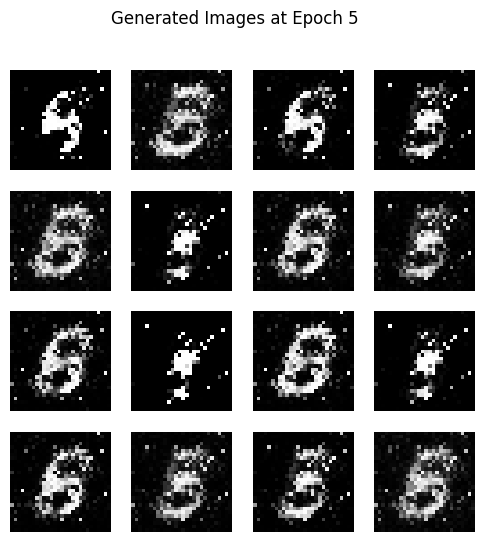

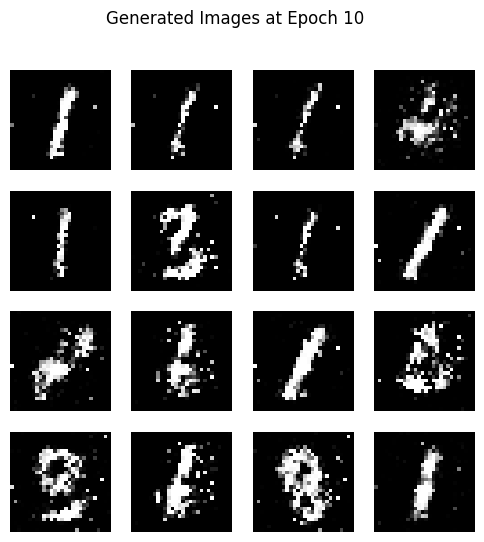

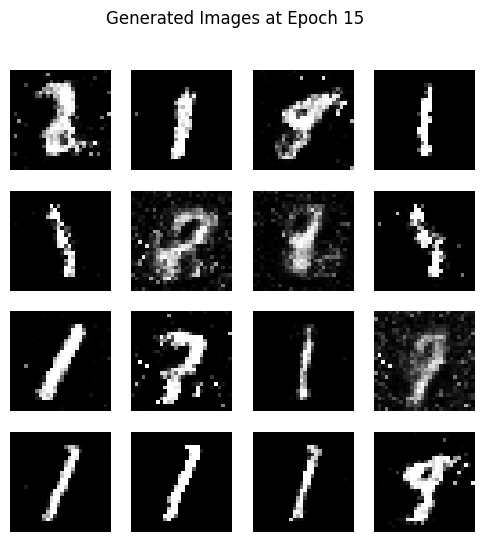

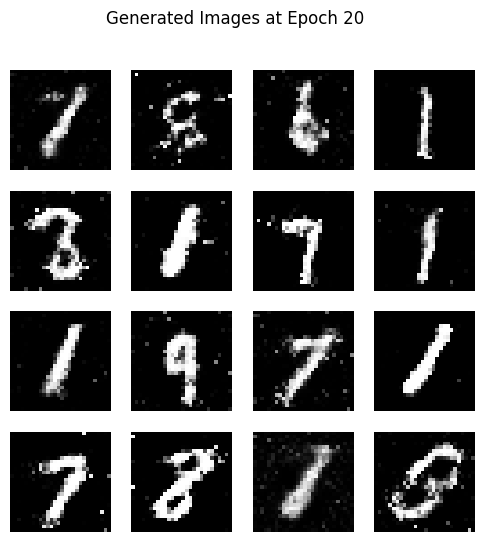

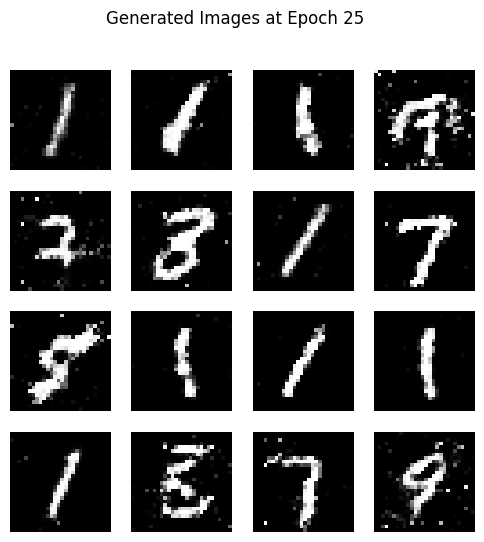

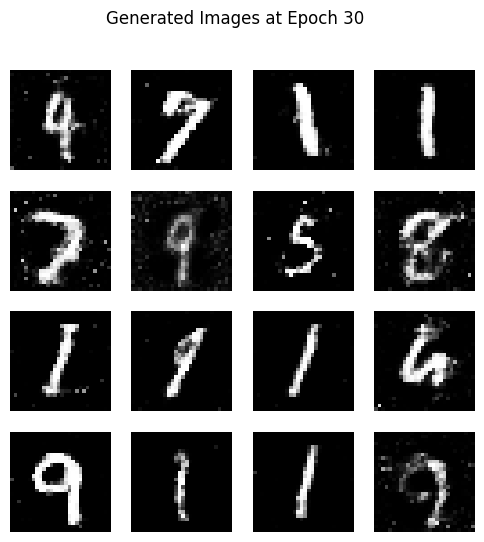

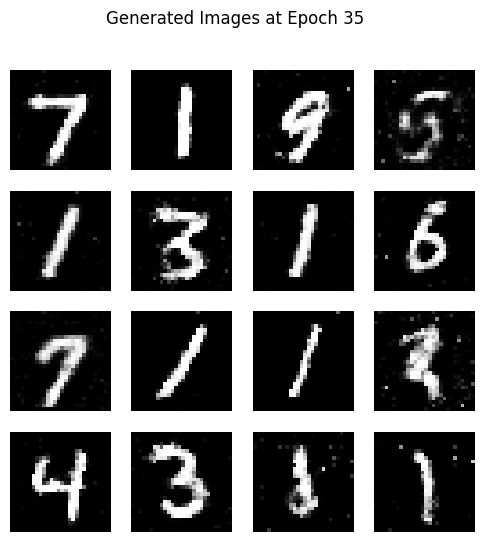

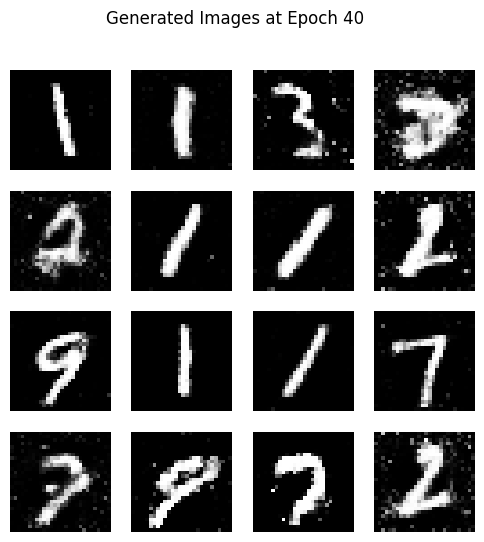

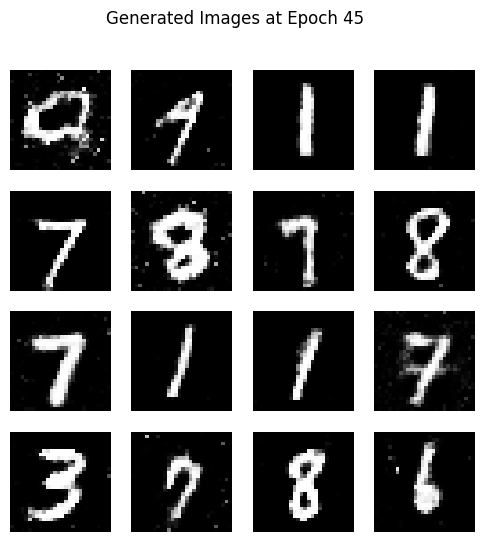

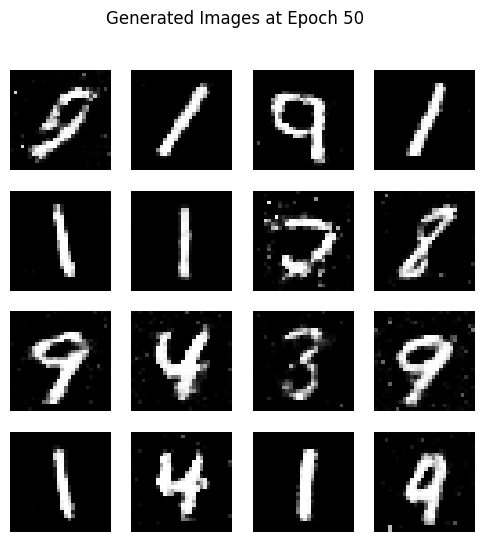

In [6]:

# Function to generate and display images
def generate_and_show_images(epoch, generator, noise_dim=100, num_images=16):
    noise = tf.random.normal([num_images, noise_dim])
    fake_images = generator(noise, training=False).numpy()

    fake_images = (fake_images + 1) / 2.0  # Rescale from [-1,1] to [0,1]

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis("off")

    plt.suptitle(f"Generated Images at Epoch {epoch+1}")
    plt.show()

# Modify training loop to visualize images every 5 epochs
epochs = 50
for epoch in range(epochs):
    for batch in train_dataset:
        g_loss, d_loss = train_step(batch)

    if (epoch + 1) % 5 == 0:  # Display images every 5 epochs
        generate_and_show_images(epoch, gen)
